# Gibbs Sampling 
Gibbs Sampling updates each component of the state by sampling from its conditional distribution given other components
This method can eliminate or reduce the need for "tuning" of a proposal distribution.

Gibbs sampling is a MCMC algorithm that repeatedly samples from the conditional distribution of one variable of the target distribution p, given all other variables. It assumes we can compute conditional distributions of one variable conditioned on all of other variables and sample exactly from these distributions.

## Gibbs Sampling for Bayesian Linear Regression


In [39]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statistics
plt.rcParams['figure.figsize'] = (10, 5)

## Step 1 : Calculate $\beta_0$ and  $\beta_1$

In [40]:
def sample_beta_0(y, x, beta_1, tau, mu_0, tau_0):
    precision = tau_0 + tau * len(y)
    mean = tau_0 * mu_0 + tau * np.sum(y - beta_1 * x)
    mean /= precision
    
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [41]:
def sample_beta_1(y, x, beta_0, tau, mu_1, tau_1):
    precision = tau_1 + tau * np.sum(x * x)
    mean = tau_1 * mu_1 + tau * np.sum( (y - beta_0) * x)
    mean /= precision
    
    return np.random.normal(mean, 1 / np.sqrt(precision))

In [42]:
def sample_tau(y, x, beta_0, beta_1, alpha, beta):
    alpha_new = alpha + len(y) / 2
    resid = y - beta_0 - beta_1 * x
    beta_new = beta + np.sum(resid * resid) / 2
    return np.random.gamma(alpha_new, 1 / beta_new)

## Step 2: Sample Synthetic Data

Text(0, 0.5, 'y')

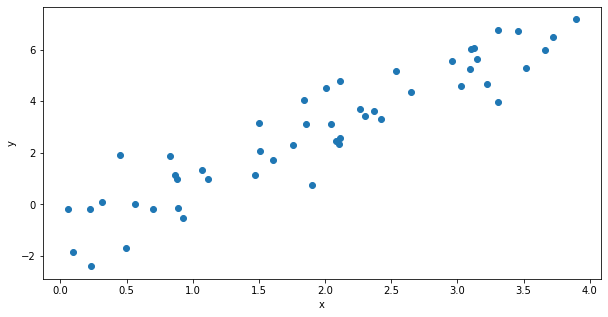

In [43]:
beta_0_true = -1
beta_1_true = 2
tau_true = 1

N = 50
x = np.random.uniform(low = 0, high = 4, size = N)
y = np.random.normal(beta_0_true + beta_1_true * x, 1 / np.sqrt(tau_true))


synth_plot = plt.plot(x, y, "o")
plt.xlabel("x")
plt.ylabel("y")

## Step 3: Write Gibbs Sampler

In [44]:
## specify initial values
init = {"beta_0": 0,
        "beta_1": 0,
        "tau": 2}

## specify hyper parameters
hypers = {"mu_0": 0,
         "tau_0": 1,
         "mu_1": 0,
         "tau_1": 1,
         "alpha": 2,
         "beta": 1}

In [45]:
def gibbs(y, x, iters, init, hypers):
    
    beta_0 = init["beta_0"]
    beta_1 = init["beta_1"]
    tau = init["tau"]
    
    trace = np.zeros((iters, 3)) ## trace to store values of beta_0, beta_1, tau
    
    for it in range(iters):
        beta_0 = sample_beta_0(y, x, beta_1, tau, hypers["mu_0"], hypers["tau_0"])
        beta_1 = sample_beta_1(y, x, beta_0, tau, hypers["mu_1"], hypers["tau_1"])
        tau = sample_tau(y, x, beta_0, beta_1, hypers["alpha"], hypers["beta"])
        trace[it,:] = np.array((beta_0, beta_1, tau))
        
    trace = pd.DataFrame(trace)
    trace.columns = ['beta_0', 'beta_1', 'tau']
        
    return trace


## Plotting Data

In [46]:
iters = 1000
trace = gibbs(y, x, iters, init, hypers)
tau_sample = gibbs(y, x, iters, init, hypers)["tau"]
beta_0_sample = gibbs(y, x, iters, init, hypers)["beta_0"]
beta_1_sample = gibbs(y, x, iters, init, hypers)["beta_1"]

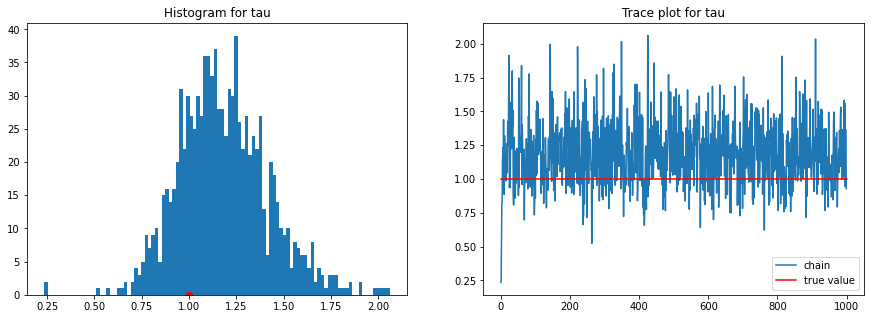

In [47]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(tau_sample, bins=100)
plt.scatter(tau_true, 0, c="r")
plt.title("Histogram for tau")
plt.subplot(1,2,2)
plt.plot(tau_sample, label="chain")
plt.plot([0, len(tau_sample)], [tau_true, tau_true], c="r", label="true value")
plt.title("Trace plot for tau")
plt.legend()
plt.show()

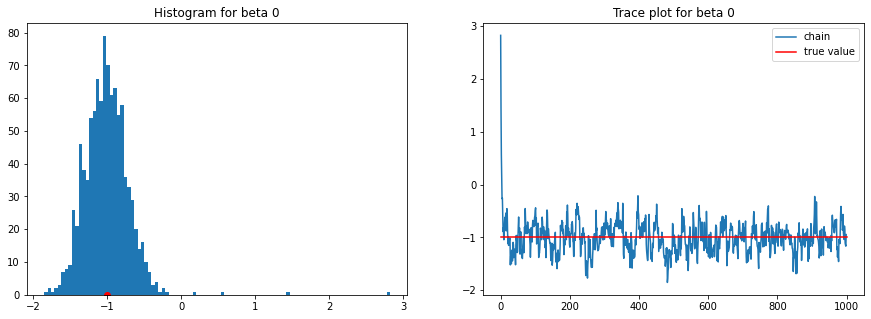

In [48]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(beta_0_sample, bins=100)
plt.scatter(beta_0_true, 0, c="r")
plt.title("Histogram for beta 0")
plt.subplot(1,2,2)
plt.plot(beta_0_sample, label="chain")
plt.plot([0, len(beta_0_sample)], [beta_0_true, beta_0_true], c="r", label="true value")
plt.title("Trace plot for beta 0")
plt.legend()
plt.show()

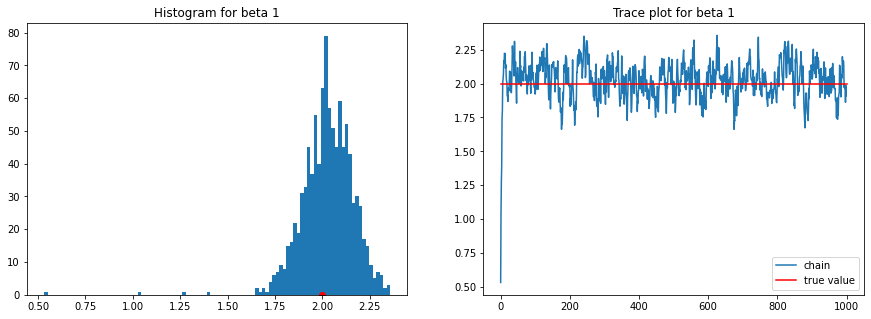

In [49]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.hist(beta_1_sample, bins=100)
plt.scatter(beta_1_true, 0, c="r")
plt.title("Histogram for beta 1")
plt.subplot(1,2,2)
plt.plot(beta_1_sample, label="chain")
plt.plot([0, len(beta_1_sample)], [beta_1_true, beta_1_true], c="r", label="true value")
plt.title("Trace plot for beta 1")
plt.legend()
plt.show()

Text(0, 0.5, 'Parameter value')

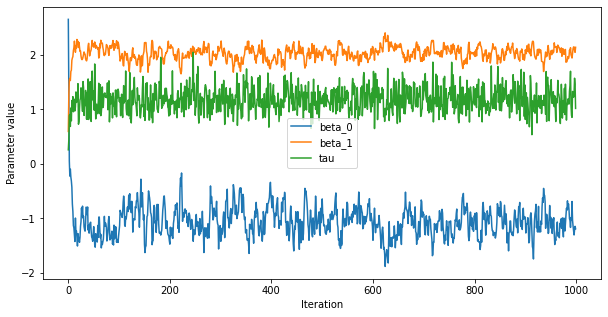

In [50]:
traceplot = trace.plot()
traceplot.set_xlabel("Iteration")
traceplot.set_ylabel("Parameter value")

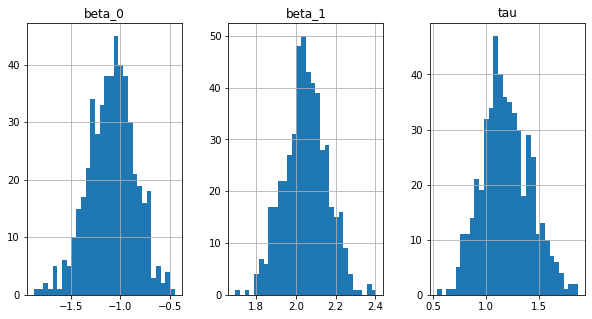

In [51]:
trace_burnt = trace[500:999]
hist_plot = trace_burnt.hist(bins = 30, layout = (1,3))
plt.axvline(x.mean(), color='k', linestyle='dashed', linewidth=1)

In [52]:
print(trace_burnt.median())
print(trace_burnt.mean())
print(trace_burnt.std())

beta_0   -1.074463
beta_1    2.048037
tau       1.175957
dtype: float64
beta_0   -1.090596
beta_1    2.049611
tau       1.190971
dtype: float64
beta_0    0.236826
beta_1    0.108031
tau       0.226733
dtype: float64


## Gibbs Sampling for Multivarative Linear Regression


### Step 1 : Simulate Data
- Sample data from model 
- Construct the matrix X, vector y and theta

In [63]:
def simulate_data(w, b, sigma, N, design_range = (-10,10)):
        designs = np.random.uniform(design_range[0], design_range[1], size=(N, w.size))
        theta = np.expand_dims(np.concatenate([w, [b]], axis=0), axis=1)
        X = np.concatenate([designs, np.ones((N, 1))], axis=1)
        y_mean = (X @ theta).squeeze()
        y = np.random.multivariate_normal(mean=y_mean, cov=np.diag([sigma**2] * N))
        
        # Plot data
        x = X[:, 0]
        plt.scatter(x, y, label="data")
        x_dense = np.linspace(design_range[0], design_range[1], 100)
        y_dense = x_dense * w[0] + b
        plt.plot(x_dense, y_dense, label="y mean")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.legend()
        plt.title("Simulated data, N="+str(N))
        plt.show()

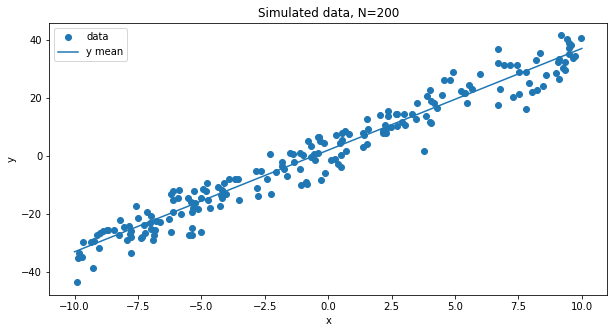

In [64]:
# True weight(s)
w = np.array([3.5])

# Input dimensionality
d = w.size

# True intercept
b = 2.0

# True standard deviation
sigma = 5.0

# Number of data points
N = 200

simulate_data(w, b, sigma, N, design_range = (-10,10))

### Step 2 : Define priors

In [58]:
# Define priors
alpha_0 = 0.1
beta_0 = 0.1
sigma_0 = 10

## Step 3: Initialize chain
- Initialize precision gamma and parameter theta
- Draw sample from the posteriors

In [67]:
gamma = 1
# Define theta as a vector with zeros
theta = np.zeros((2,1))